In [1]:
'''The system can:
Decide what to retrieve
Retrieve multiple times
Judge its own answer
Stop only when confident'''

'The system can:\nDecide what to retrieve\nRetrieve multiple times\nJudge its own answer\nStop only when confident'

### Agent State

In [2]:
from typing import TypedDict,List

class AgentState(TypedDict):
    question: str
    documents: List[str]
    ans: str
    needs_retrieval: bool
    iterations: int

### Planner Node (agent decides retrieval)

In [3]:
from langchain_groq import ChatGroq
import os
llm = ChatGroq(groq_api_key= os.getenv("NEW_GROQ_API_KEY") , model_name="llama-3.1-8b-instant",temperature=0.1,max_tokens=1024)

c:\Users\Himanshu\Desktop\GenAi-Project\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def plan(state: AgentState) -> AgentState:
    question = state["question"]
    prompt = f"""
You are an AI controller in a Retrieval-Augmented Generation (RAG) system.

Task:
Decide whether external knowledge retrieval is REQUIRED to answer the user query correctly and confidently.

Rules:
- Choose yes if the query:
  - Refers to specific documents, standards, datasets, or user-provided files
  - Requires precise, technical, or domain-specific information
  - Cannot be answered confidently without external sources
- Choose no if the query:
  - Is conversational or opinion-based
  - Can be answered accurately using general knowledge alone

Important:
- If you are uncertain, choose yes.

User Query:
"{question}"

Respond with ONLY one word:
yes or no

"""
    decision = llm.invoke(prompt).content.strip().lower()
    return{
        **state,
        "needs_retrieval": decision == "yes"
    }

Retrieval Node (ITERATIVE)

In [5]:
from langchain_core.documents import Document
from sentence_transformers import SentenceTransformer
from pinecone.grpc import PineconeGRPC as Pinecone

def custom_retriever(question: str):
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
    query_embedding = model.encode(question).tolist()
    pinecone_api_key = os.getenv("PINECONE_API_KEY")
    pinecone_env = os.getenv("PINECONE_ENVIRONMENT")
    pc = Pinecone(api_key=pinecone_api_key)
    index_name = "ilibrary-backend-documentation-rag"
    host = os.getenv("PINECONE_HOST")
    index = pc.Index(host=host)
    result = index.query(
        vector= query_embedding,
        top_k=5,
        namespace="rag-docs",
        include_metadata=True
    )
    return [
        Document(
            page_content=match["metadata"]["text"],
            metadata=match["metadata"]
        )
        for match in result["matches"]
    ]


In [6]:
def retrieve_document(state:AgentState) -> AgentState:
    docs = custom_retriever(state["question"])
    return{
        **state,
        "documents":state["documents"] + [d.page_content for d in docs]
    }

### Generator Node (grounded)

In [7]:
def generate_ans(state:AgentState) -> AgentState:
    question = state["question"]
    docs = state["documents"]
    if docs:
        context = "\n\n".join(docs[:5])
        prompt = f"""
        Answer the question using ONLY the context below.
        If the context is insufficient, say so clearly.

        Context:
        {context}

        Question:
        {question}
        """
    else:
        prompt = f"Answer the question:\n{question}"
    answer = llm.invoke(prompt).content
    return{
        **state,
        "ans": answer,
        "iterations": state["iterations"] + 1
    }

### Evaluator Node (THIS makes it agentic)

In [8]:
from langgraph.graph import END
def evaluate(state: AgentState) -> str:
    prompt = f"""
    Question:
    {state['question']}

    Answer:
    {state['ans']}

    Decide if the answer is:
    - complete
    - correct
    - grounded in context

    Reply ONLY with:
    - sufficient
    - insufficient
    """
    verdict = llm.invoke(prompt).content.strip().lower()
    if verdict == "insufficient" and state['iterations'] < 3:
        return "retrieve"
    return END

### Build Agentic LangGraph

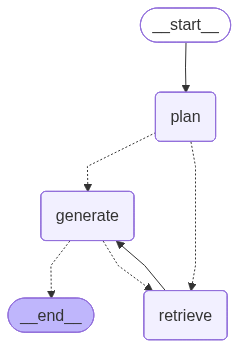

In [9]:
from langgraph.graph import StateGraph

workflow = StateGraph(AgentState)
workflow.add_node("plan",plan)
workflow.add_node("retrieve",retrieve_document)
workflow.add_node("generate",generate_ans)

workflow.set_entry_point("plan")

workflow.add_conditional_edges(
    "plan",
    lambda s: "retrieve" if s["needs_retrieval"] else "generate",
    {
        "retrieve": "retrieve",
        "generate": "generate"
    }
)
workflow.add_edge("retrieve", "generate")
workflow.add_conditional_edges(
    "generate",
    evaluate,
    {
        "retrieve": "retrieve",
        END: END
    }
)
agentic_rag = workflow.compile()
agentic_rag

In [10]:
def ask_question(question:str):
    return agentic_rag.invoke(
        {
        "question": question,
        "documents": [],
        "ans": "",
        "needs_retrieval": False,
        "iterations": 0
        }
    )

In [13]:
answer = ask_question("How many entities are there in this project?")
print(answer['ans'])
print('Iterations: ' + str(answer['iterations'])) 

There are 5 entities in this project: 

1. User
2. Seat
3. Booking
4. Subscription
5. Payment
Iterations: 3


In [15]:
answer = ask_question("Explain the database schema used in the application")
print(answer['ans'])
print('Iterations: ' + str(answer['iterations'])) 

The database schema used in the application is a relational model that balances normalization with query performance. It is designed around the core entities of the library system.

The schema consists of the following tables:

1. `users`: Stores user information, including `id`, `name`, `email`, `password_hash`, and `roles`. The `email` field has a `UNIQUE` constraint to prevent duplicate accounts.

2. `subscriptions`: Stores subscription details for each user.

Additionally, there are two other tables mentioned in the context, but not explicitly listed as part of the schema:

1. `seat`: Represents the physical inventory, with fields `seat_number`, `status` (which can be `AVAILABLE`, `BOOKED`, or `OCCUPIED`).

2. `booking`: Not explicitly mentioned, but implied as part of the system's state, which persists all application state, including users, seats, bookings, subscriptions, etc.

The database is a MySQL database, recommended to be hosted on AWS RDS for production.
Iterations: 3


In [16]:
answer = ask_question("What authentication mechanism is implemented?")
print(answer['ans'])
print('Iterations: ' + str(answer['iterations'])) 

Based on the provided context, the authentication mechanism implemented is:

1.  **Username-Password Authentication**: The user sends their email and password to `POST /auth/login`, which is then compared with the stored hash in the database using BCrypt.
2.  **JSON Web Token (JWT) Authentication**: After successful authentication, a JWT token is generated and returned to the client. This token is then sent in the `Authorization: Bearer <token>` header for subsequent requests to access protected endpoints.

Additionally, the system implements **Role-Based Access Control (RBAC)** using Spring Security's annotations, such as `@PreAuthorize("hasRole('ADMIN')")`, to enforce access control based on user roles.
Iterations: 3


In [17]:
answer = ask_question("Which services interact with the user module?")
print(answer['ans'])
print('Iterations: ' + str(answer['iterations'])) 

Based on the provided context, the following services interact with the user module:

1. `UserService`
2. `JwtService` (for JWT creation and validation)
3. `UserInfoService` (for security-specific operations and integrating with Spring Security to load user data)
Iterations: 3


In [19]:
answer = ask_question("Explain REST API in simple terms")
print(answer['ans'])
print('Iterations: ' + str(answer['iterations'])) 
print(answer['needs_retrieval'])

**What is a REST API?**

A REST API (Representational State of Resource) is a way for different applications to communicate with each other over the internet. It's like a messenger that helps different systems talk to each other.

**Think of it like a Restaurant**

Imagine you're at a restaurant and you want to order food. You can't just walk into the kitchen and start making your own food, right? Instead, you give your order to the waiter, and they take it to the kitchen staff. They then prepare your food and give it back to the waiter, who brings it to you.

In this scenario:

* **You** are like the client (the application that's making the request)
* **The waiter** is like the API (the messenger that helps you communicate with the kitchen)
* **The kitchen** is like the server (the system that's providing the service)

**How does it work?**

Here's a simple example:

1. **You** (the client) send a request to the **waiter** (the API) to get a list of menu items.
2. The **waiter** (the